# Tweets Sentiment Analysis using NLTK

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import pandas as pd
import os
import csv as csv
import nltk as nltk
import re
from nltk.corpus import wordnet as wn
import nltk as nltk
import re
from nltk.corpus import wordnet as wn
from nltk.tokenize.casual import TweetTokenizer
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

%matplotlib inline

In [2]:
csvTweetData = "testdata.manual.2009.06.14.csv"
df = pd.read_csv(csvTweetData,header=None)

In [38]:
cols = {0:"popularity",1:"id",2:"date",3:"associated_request",4:"user",5:"text"}
df = df.rename(columns=cols)

### Abrevs Import

In [4]:
# Big problems with python 3.5 and encoding
dataAbrevs = open('abrevs.txt', encoding='utf-8'
                  , errors='ignore')
dicoSlang = {}
for line in dataAbrevs:
    line = line.strip(' \t\n\r').split('\t')
    dicoSlang[line[0]] = str(line[1])

In [5]:
dicoSlang.items()

dict_items([('dbau', 'doing business as usual'), ('btw', 'by the way'), ('milf', 'mother I would like to fuck'), ('ldr', 'longdistancerelationship'), ('pir', 'parent in room'), ('thx', 'thanks'), ('hhis', 'hanging head in shame'), ('cyo', 'see you online'), ('u', 'you'), ('lol', 'laugh out loud'), ('cnp', 'continued in my next post'), ('luv', 'love'), ('imnsho', 'in my not so humble opinion'), ('wtf', 'what the fuck'), ('fwiw', "for what it's worth"), ('aight', 'alright'), ('sot', 'short of time'), ('ur', 'you are'), ('hagn', 'have a good night'), ('fyi', 'for your information'), ('uw', 'youre welcome'), ('thanx', 'thanks'), ('ru', 'are you'), ('cul8r', 'see you later'), ('ppl', 'people'), ('wb', 'welcome back'), ('lmao', 'laugh my ass off'), ('adn', 'any day now'), ('omg', 'oh my god'), ('cp', 'chat post'), ('m/f', 'male or female'), ('gfn', 'gone for now'), ('afaik', 'as far as I know'), ('a/s/l', 'age, sex, location'), ('gf', 'girlfriend'), ('wtg', 'way to go'), ('cya', 'bye'), ('im

In [6]:
slang_df = pd.DataFrame.from_dict(dicoSlang, orient='index').reset_index()
slang_df.columns = ["key", "value"]
dico_slang = slang_df.to_dict()
slang_df.head()

,key,value
0,dbau,doing business as usual
1,btw,by the way
2,milf,mother I would like to fuck
3,ldr,longdistancerelationship
4,pir,parent in room


### Text treatment and cleaning tweets

In [7]:
count_at = count_hastag = 0

def pretreat(tweet):
    global count_at , count_hastag
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = TweetTokenizer().tokenize(tweet)
    
    for word in tweet:
        if word[0] == '@':count_at +=1
        elif word[0] == '#': count_hastag +=1

    tweet = [a.lower() for a in tweet if not (a.startswith("#") or a.startswith("@"))]
    return tweet

df['tokenized_no_punc'] = df.text.apply(pretreat)
print("There were {} @ symbols and {} #".format(count_at, count_hastag))

There were 128 @ symbols and 52 #


In [8]:
def replace_slang(liste):
    list_tmp = []

    for word in liste:
        found = False
        for i in range(len(dico_slang["value"])):
            cle = dico_slang["key"][i]
            if cle == word:
                value = nltk.word_tokenize(dico_slang["value"][i])
                if isinstance(value, list):
                    for word in value:
                        list_tmp.append(word)
                else:
                    list_tmp.append(value)
                found = True
                break
        if not found:
              list_tmp.append(word)
    
    return list_tmp

df['content_no_slang'] = df.tokenized_no_punc.apply(replace_slang)

### POS Tagging

In [9]:
verb_counts = 0

def pos_tag(embeded_list):
    global verb_counts
    result = nltk.pos_tag(embeded_list)
    for word, tag in result:
        if tag.startswith("VB") or tag == "MD":
            verb_counts += 1
    return  result

df['pos_tag'] = df.content_no_slang.apply(pos_tag)

print ("THERE ARE {} VERBS.".format(verb_counts))

df.head()

THERE ARE 1204 VERBS.


,popularity,id,date,assiciated_request,user,text,tokenized_no_punc,content_no_slang,pos_tag
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,"[i, loooooooovvvvvveee, my, kindle, 2, ., not,...","[i, loooooooovvvvvveee, my, kindle, 2, ., not,...","[(i, NN), (loooooooovvvvvveee, VBP), (my, PRP$..."
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,"[reading, my, kindle, 2, ..., love, it, ..., l...","[reading, my, kindle, 2, ..., love, it, ..., l...","[(reading, VBG), (my, PRP$), (kindle, NN), (2,..."
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...","[ok, ,, first, assesment, of, the, ..., it, fu...","[ok, ,, first, assesment, of, the, ..., it, fu...","[(ok, NN), (,, ,), (first, JJ), (assesment, NN..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,"[you'll, love, your, kindle, 2, ., i've, had, ...","[you'll, love, your, kindle, 2, ., i've, had, ...","[(you'll, NNS), (love, VB), (your, PRP$), (kin..."
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,"[fair, enough, ., but, i, have, the, kindle, 2...","[fair, enough, ., but, i, have, the, kindle, 2...","[(fair, JJ), (enough, RB), (., .), (but, CC), ..."


### Sentiment analysis

In [10]:
from nltk.corpus import wordnet as wn
from nltk.corpus.reader.sentiwordnet import SentiWordNetCorpusReader, SentiSynset
swn = SentiWordNetCorpusReader('./','SentiWordNet_3.0.0_20130122.txt')

In [37]:
# Test of swn
swn.senti_synset('breakdown.n.03')

SentiSynset('breakdown.n.03')

### Before methods, a function for ploting results

In [39]:
def plot_results(y_pred):
    cnf_matrix = confusion_matrix(df.popularity.values, df[y_pred].values)
    cnf_matrix_df = pd.DataFrame(cnf_matrix,columns=["negative", "neutral", "positive"])
    cnf_matrix_df.set_index(["negative", "neutral", "positive"])

    plt.figure()
    sns.heatmap(cnf_matrix_df,annot=True)
    plt.show()
    
    print(classification_report(df.popularity.values, df[y_pred].values, target_names=["negative", "neutral", "positive"]))

### Algorithm 1 - sentiwordnet dictionnary

In [40]:
def get_score(pos_tag_list):
    my_synsets = []
    positive_sum = 0
    negative_sum = 0
    synset = None
    
    for pos_tag in pos_tag_list:
        
        if  pos_tag[1].startswith("VB"): 
            synset = wn.synsets(pos_tag[0], pos='v')
        elif pos_tag[1] == "JJ" :
            synset = wn.synsets(pos_tag[0], pos="a")
        elif pos_tag[1] == "ADV" :
            synset = wn.synsets(pos_tag[0], pos="r")
        elif pos_tag[1].startswith("N"):
            synset = wn.synsets(pos_tag[0], pos="n")
        
        if synset and len(synset) > 1:
                my_synsets.append(synset[0])
    
    for x in my_synsets:
        res = swn.senti_synset(x.name())
        if res is not None :
            positive_sum = positive_sum + res.pos_score()
            negative_sum = negative_sum + res.neg_score()
    
    return positive_sum if positive_sum >= negative_sum else -negative_sum

In [41]:
def classify_tweet(score):
    return 0 if score < 0 else 4

In [42]:
df['score_1'] = df.pos_tag.apply(get_score)
df["alg_popularity_1"] = df['score_1'].apply(classify_tweet)
df.head(5)

,popularity,id,date,assiciated_request,user,text,tokenized_no_punc,content_no_slang,pos_tag,score_1,alg_popularity_1,score_2,alg_popularity_no_neutral_2,alg_popularity_2,score_3,alg_popularity_3
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,"[i, loooooooovvvvvveee, my, kindle, 2, ., not,...","[i, loooooooovvvvvveee, my, kindle, 2, ., not,...","[(i, NN), (loooooooovvvvvveee, VBP), (my, PRP$...",2.875,4,2.875,4,4,2.875,4
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,"[reading, my, kindle, 2, ..., love, it, ..., l...","[reading, my, kindle, 2, ..., love, it, ..., l...","[(reading, VBG), (my, PRP$), (kindle, NN), (2,...",2.875,4,2.875,4,4,2.875,4
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...","[ok, ,, first, assesment, of, the, ..., it, fu...","[ok, ,, first, assesment, of, the, ..., it, fu...","[(ok, NN), (,, ,), (first, JJ), (assesment, NN...",0.000,4,0.000,4,2,0.000,2
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,"[you'll, love, your, kindle, 2, ., i've, had, ...","[you'll, love, your, kindle, 2, ., i've, had, ...","[(you'll, NNS), (love, VB), (your, PRP$), (kin...",2.375,4,2.375,4,4,21.375,4
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,"[fair, enough, ., but, i, have, the, kindle, 2...","[fair, enough, ., but, i, have, the, kindle, 2...","[(fair, JJ), (enough, RB), (., .), (but, CC), ...",3.000,4,3.000,4,4,11.000,4


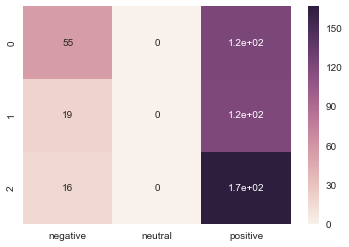

             precision    recall  f1-score   support

   negative       0.61      0.31      0.41       177
    neutral       0.00      0.00      0.00       139
   positive       0.41      0.91      0.56       182

avg / total       0.37      0.44      0.35       498



In [43]:
plot_results("alg_popularity_1")    

### Algorithm of detection v2 - negations and modifiers

In [18]:
path_negation = "NegatingWordList.txt"
negations_df =  pd.read_csv(path_negation, header=None, names = ["negation"], sep ="\n")
negation_list = list(negations_df.values.ravel())

path_booster = "BoosterWordList.txt"
booster_df =  pd.read_csv(path_booster, header=None, names = ["booster", "valence"], sep ="\t")
booster_list = list(booster_df.booster.values)

In [19]:
negations_df.head(5)

,negation
0,aren't
1,arent
2,can't
3,cannot
4,cant


In [20]:
booster_df.head(5)

,booster,valence
0,absolutely,1
1,definitely,1
2,extremely,2
3,fuckin,2
4,fucking,2


In [21]:
def get_score2(pos_tag_list):
    my_synsets = []
    positive_sum = 0
    negative_sum = 0
    synset = None
    
    for  idx  in range(len(pos_tag_list)):
        pos_tag = pos_tag_list[idx]
        
        if  pos_tag[1].startswith("VB"): 
            synset = wn.synsets(pos_tag[0], pos='v')
        elif pos_tag[1] == "JJ" :
            synset = wn.synsets(pos_tag[0], pos="a")
        elif pos_tag[1] == "ADV" :
            synset = wn.synsets(pos_tag[0], pos="r")
        elif pos_tag[1].startswith("N"):
            synset = wn.synsets(pos_tag[0], pos="n")
        
        previous_word = pos_tag_list[idx-1][0] if idx > 0 else ""
        
        if synset and len(synset) > 1:
            my_synsets.append((synset[0], previous_word))
    
    for idx in range(len(my_synsets)):
        current_synset = my_synsets[idx][0]
        previous_word = my_synsets[idx][1]
        result = swn.senti_synset(current_synset.name())
        
        follows_booster = True if previous_word.lower() in booster_list else False
        follows_negation = True if previous_word.lower() in negation_list else False
        
        multiplier = 2 if follows_booster else 1
        if result is not None :
            positive_sum += multiplier * result.pos_score() if not follows_negation else result.neg_score()
            negative_sum += multiplier * result.neg_score() if not follows_negation else result.pos_score()
    
    return positive_sum if positive_sum >= negative_sum else -negative_sum

In [22]:
def classify_tweet_2(score):
    sentiment =  2 
    if score < -0.25 : sentiment = 0
    if score > 0.25 : sentiment = 4 
    return sentiment

In [23]:
df['score_2'] = df.pos_tag.apply(get_score2)
df["alg_popularity_no_neutral_2"] = df['score_2'].apply(classify_tweet)
df["alg_popularity_2"] = df['score_2'].apply(classify_tweet_2)

df.head(3)

,popularity,id,date,assiciated_request,user,text,tokenized_no_punc,content_no_slang,pos_tag,score_1,alg_popularity_1,score_2,alg_popularity_no_neutral_2,alg_popularity_2
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,"[i, loooooooovvvvvveee, my, kindle, 2, ., not,...","[i, loooooooovvvvvveee, my, kindle, 2, ., not,...","[(i, NN), (loooooooovvvvvveee, VBP), (my, PRP$...",2.875,4,2.875,4,4
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,"[reading, my, kindle, 2, ..., love, it, ..., l...","[reading, my, kindle, 2, ..., love, it, ..., l...","[(reading, VBG), (my, PRP$), (kindle, NN), (2,...",2.875,4,2.875,4,4
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...","[ok, ,, first, assesment, of, the, ..., it, fu...","[ok, ,, first, assesment, of, the, ..., it, fu...","[(ok, NN), (,, ,), (first, JJ), (assesment, NN...",0.000,4,0.000,4,2


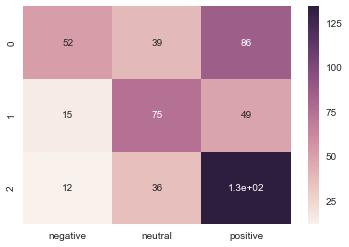

             precision    recall  f1-score   support

   negative       0.66      0.29      0.41       177
    neutral       0.50      0.54      0.52       139
   positive       0.50      0.74      0.59       182

avg / total       0.56      0.52      0.51       498



In [36]:
plot_results("alg_popularity_2")    

### Algorithm of detection v3 - emoticons

In [25]:
path_emoticon = "EmoticonLookupTable.txt"
emoticon_df =  pd.read_csv(path_emoticon, header=None, names = ["smiley", "valence"], sep ="\t")
emoticon_list = list(emoticon_df.smiley.values.ravel())

positive_emoticons = list(emoticon_df[emoticon_df.valence == 1].smiley.values)
negative_emoticons = list(emoticon_df[emoticon_df.valence == -1].smiley.values)

In [26]:
def get_score3(pos_tag_list, **kwargs):
        
    my_synsets = []
    positive_sum = 0
    negative_sum = 0
    synset = None
    bonus_positive_emoticon = 0
    bonus_negative_emoticon = 0
    
    for  idx  in range(len(pos_tag_list)):
        pos_tag = pos_tag_list[idx]
        
        if  pos_tag[1].startswith("VB"): 
            synset = wn.synsets(pos_tag[0], pos='v')
        elif pos_tag[1] == "JJ" :
            synset = wn.synsets(pos_tag[0], pos="a")
        elif pos_tag[1] == "ADV" :
            synset = wn.synsets(pos_tag[0], pos="r")
        elif pos_tag[1].startswith("N"):
            synset = wn.synsets(pos_tag[0], pos="n")
        
        previous_word = pos_tag_list[idx-1][0] if idx > 0 else ""
        
        if pos_tag[0] in kwargs["positive_emoticons"]:
            bonus_positive_emoticon += 1
        if pos_tag[0] in kwargs["negative_emoticons"]:
            bonus_negative_emoticon += 1
        
        if synset and len(synset) > 1:
            my_synsets.append((synset[0], previous_word))
        
    
    for idx in range(len(my_synsets)):
        current_synset = my_synsets[idx][0]
        previous_word = my_synsets[idx][1]
        result = swn.senti_synset(current_synset.name())
        
        follows_booster = True if previous_word.lower() in booster_list else False
        follows_negation = True if previous_word.lower() in negation_list else False
        
        multiplier = 2 if follows_booster else 1
        if result is not None :
            positive_sum += multiplier * result.pos_score() if not follows_negation else result.neg_score()
            negative_sum += multiplier * result.neg_score() if not follows_negation else result.pos_score()
        
        positive_sum += bonus_positive_emoticon
        negative_sum += bonus_negative_emoticon
    
    return positive_sum if positive_sum >= negative_sum else -negative_sum

In [34]:
df['score_3'] = df.pos_tag.apply(get_score3, positive_emoticons=positive_emoticons, negative_emoticons=negative_emoticons)
df["alg_popularity_3"] = df['score_3'].apply(classify_tweet_2)

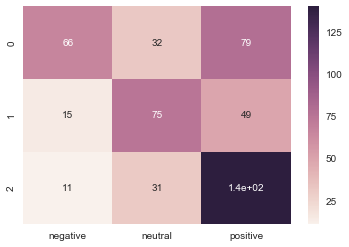

             precision    recall  f1-score   support

   negative       0.72      0.37      0.49       177
    neutral       0.54      0.54      0.54       139
   positive       0.52      0.77      0.62       182

avg / total       0.60      0.56      0.55       498



In [35]:
plot_results("alg_popularity_3")

### End